# Multiple Outputs Gaussian Processes

# Gaussian Process Summer School, Melbourne, Australia
### 25th-27th February 2015
### Neil D. Lawrence

In this lab we are going to build on yestereday's work by looking at multiple output Gaussian processes

## Getting started: Modelling Multiple Outputs

Just as in the first lab, we firstly specify to include plots in the notebook and to import relevant libraries.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import GPy
import pods
from IPython.display import display

### Running Example

The first think we will look at is a multiple output model. Our aim is to jointly model all *sprinting* events from olympics since 1896. Data is provided by Rogers & Girolami's "First Course in Machine Learning". Firstly, let's load in the data.

In [3]:
data = pods.datasets.olympic_sprints()
X = data['X']
y = data['Y']
print data['info'], data['details']

Olympics sprint event winning for men and women to 2008. Data is from Rogers and Girolami's First Course in Machine Learning. Data from the textbook 'A First Course in Machine Learning'. Available from http://www.dcs.gla.ac.uk/~srogers/firstcourseml/.


When using data sets it's good practice to cite the originators of the data, you can get information about the source of the data from `data['citation']`

In [4]:
print data['citation']

A First Course in Machine Learning. Simon Rogers and Mark Girolami: Chapman & Hall/CRC, ISBN-13: 978-1439824146


The data consists of all the male and female sprinting data for 100m, 200m and 400m since 1896 (six outputs in total). The ouput information can be found from: `data['output_info']`

In [5]:
print data['output_info']

{0: '100m Men', 1: '100m Women', 2: '200m Men', 3: '200m Women', 4: '400m Men', 5: '400m Women'}


In GPy we deal with multiple output data in a particular way. We specify the output we are interested in for modelling as an additional *input*. So whilst for this data, normally, the only input would be the year of the event. We additionally have an input giving the index of the output we are modelling. This can be seen from examining `data['X']`.

In [36]:
print('First column of X contains the olympic years.')
print(np.unique(data['X'][:, 0]))
print('Second column of X contains the event index.')
print(np.unique(data['X'][:, 1]))

First column of X contains the olympic years.
[ 1896.  1900.  1904.  1906.  1908.  1912.  1920.  1924.  1928.  1932.
  1936.  1948.  1952.  1956.  1960.  1964.  1968.  1972.  1976.  1980.
  1984.  1988.  1992.  1996.  2000.  2004.  2008.]
Second column of X contains the event index.
[ 0.  1.  2.  3.  4.  5.]


Now let's plot the data

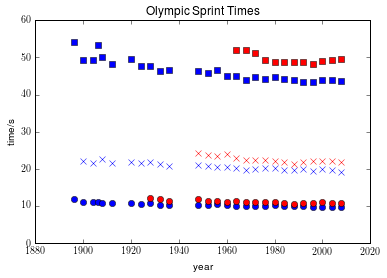

In [6]:
markers = ['bo', 'ro', 'bx', 'rx', 'bs', 'rs']
for i in range(6):
    # extract the event 
    x_event = X[np.nonzero(X[:, 1]==i), 0]
    y_event = y[np.nonzero(X[:, 1]==i), 0]
    plt.plot(x_event, y_event, markers[i])
plt.title('Olympic Sprint Times')
plt.xlabel('year')
plt.ylabel('time/s')

In the plot above red is women's events, blue is men's. Squares are 400 m, crosses 200m and circles 100m. Not all events were run in all years, for example the women's 400 m only started in 1964.

We will look at modelling the data using coregionalization approaches described in this morning's lecture. We introduced these approaches through the Kronecker product. To indicate we want to construct a covariance function of this type in GPy we've overloaded the `**` operator. Stricly speaking this operator means to the power of (like `^` in MATLAB). But for covariance functions we've used it to indicate a tensor product. The linear models of coregionalization we introduced in the lecture were all based on combining a matrix with a standard covariance function. We can think of the matrix as a particular type of covariance function, whose elements are referenced using the event indices. I.e. $k(0, 0)$ references the first row and column of the coregionalization matrix. $k(1, 0)$ references the second row and first column of the coregionalization matrix. Under this set up, we want to build a covariance where the first column from the features (the years) is passed to a covariance function, and the second column from the features (the event number) is passed to the coregionalisation matrix. Let's start by trying a intrinsic coregionalisation model (sometimes known as multitask Gaussian processes). Let's start by checking the help for the `coregionalize` covariance.

In [7]:
GPy.kern.Coregionalize?

The coregionalize matrix, $\mathbf{B}$, is itself is constructed from two other matrices, $\mathbf{B} = \mathbf{W}\mathbf{W}^\top + \text{diag}(\boldsymbol{\kappa})$. This allows us to specify a low rank form for the coregionalization matrix. However, for our first example we want to specify that the matrix $\mathbf{B}$ is not constrained to have a low rank form. 

In [8]:
kern = GPy.kern.RBF(1, lengthscale=80)**GPy.kern.Coregionalize(1,output_dim=6, rank=5)
display(kern)

mul.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,80.0,+ve,
coregion.W,"(6, 5)",,
coregion.kappa,"(6,)",+ve,


Note here that the rank we specify is that of the $\mathbf{W}\mathbf{W}^\top$ part. When this part is combined with the diagonal matrix from $\mathbf{\kappa}$ the matrix $\mathbf{B}$ is totally general. This covariance function can now be used in a standard Gaussian process regression model. Let's build the model and optimize it.

In [10]:
model = GPy.models.GPRegression(X, y, kern)
model.optimize()

We can plot the results using the ability to 'fix inputs' in the `model.plot()` function. We can specify that column 1 should be fixed to event number 2 by passing `fixed_inputs = [(1, 2)]` to the model. To plot the results for all events on the same figure we also specify `fignum=1` in the loop as below. 

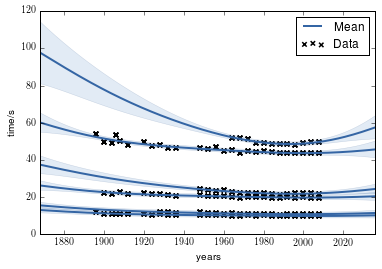

In [11]:
fig, ax = plt.subplots()
for i in range(6):
    model.plot(fignum=1,fixed_inputs=[(1, i)],ax=ax,legend=i==0)
plt.xlabel('years')
plt.ylabel('time/s')

There is a lot we can do with this model. First of all, each of the races is a different length, so the series have a different mean. We can include another coregionalization term to deal with the mean. Below we do this and reduce the rank of the coregionalization matrix to 1.

In [12]:
kern1 = GPy.kern.RBF(1, lengthscale=80)**GPy.kern.Coregionalize(1,output_dim=6, rank=1)
kern2 = GPy.kern.Bias(1)**GPy.kern.Coregionalize(1,output_dim=6, rank=1)
kern = kern1 + kern2

In [13]:
model = GPy.models.GPRegression(X, y, kern)
model.optimize()

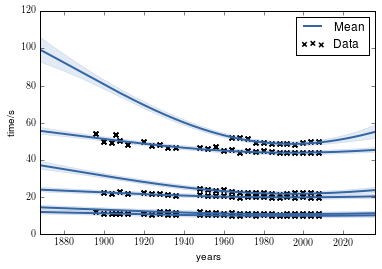

In [14]:
fig, ax = plt.subplots()
for i in range(6):
    model.plot(fignum=1,fixed_inputs=[(1, i)],ax=ax,legend=i==0)
plt.xlabel('years')
plt.ylabel('time/s')

This is a simple form of the linear model of coregionalization. Note how confident the model is about what the women's 400 m performance would have been. You might feel that the model is being over confident in this region. Perhaps we are forcing too much sharing of information between the sprints. We could return to the intrinsic coregionalization model and force the two base covariance functions to share the same coregionalization matrix.

In [33]:
m.plot?

In [15]:
kern1 = GPy.kern.RBF(1, lengthscale=80) + GPy.kern.Bias(1)
kern1.name = 'rbf_plus_bias'
kern2 = GPy.kern.Coregionalize(1,output_dim=6, rank=5)
kern = kern1**kern2
kern.name = 'product'
display(kern)

product.,value,constraints,priors
rbf_plus_bias.rbf.variance,1.0,+ve,
rbf_plus_bias.rbf.lengthscale,80.0,+ve,
rbf_plus_bias.bias.variance,1.0,+ve,
coregion.W,"(6, 5)",,
coregion.kappa,"(6,)",+ve,


In [16]:
model = GPy.models.GPRegression(X, y, kern)
model.optimize()

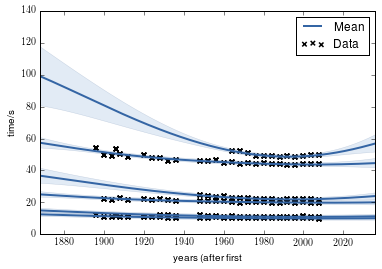

In [17]:
fig, ax = plt.subplots()
for i in range(6):
    model.plot(fignum=1,fixed_inputs=[(1, i)],ax=ax,legend=(i==0))
plt.xlabel('years (after first ')
plt.ylabel('time/s')

### Exercise 1

Can you fix the issue with over confidence in this model? Some things you might try include (a) adding additional covariance functions to handle shorter lengthscale effects. (b) Changing the rank of the coregionalization matrix. (c) Adding a coregionalized noise model using `GPy.kern.white()`.

In [18]:
# Question 1 answer here

Predictions in the multioutput case can be very effected by our covariance function *design*. This reflects the themes we saw on the first day where the importance of covariance function choice was emphasized at design time. 

Can you build a covariance matrix that coregionalizes separately over the sex of the athletes and the event identity? Does this matrix perform better?

In [19]:
# set up the inputs to index sex and event separately.
X2 = np.zeros((X.shape[0], 3))
X2[:, 0] = X[:, 0]
X2[:, 1] = np.remainder(X[:, 1],2) == 1 # Gender
X2[:, 2] = np.floor(X[:, 1]/2)          # Event

In [20]:
X2mean = X2[:,0].mean()
# Zero mean X for the linear trend to be feasible
X2m = X2.copy()
X2m[:,0] -= X2mean

In [21]:
kern = ((GPy.kern.RBF(1, variance=1, lengthscale=70)+
         GPy.kern.Linear(1, 1, active_dims=[0])+
         GPy.kern.White(1)+
         GPy.kern.Bias(1, 1))
        *GPy.kern.Coregionalize(1, output_dim=2, rank=1, active_dims=1, name='gender')
        *GPy.kern.Coregionalize(1, output_dim=3, rank=1, active_dims=2, name='event')
       )

In [22]:
#display(kern)
#print "First coregion:", [(k.name, k.active_dims) for k in kern.parts[0].parts]
#print "Second         ", [(k.name, k.active_dims) for k in kern.parts[0].parts[1].parts]

model = GPy.models.GPRegression(X2m, y, kern, normalizer=True) 
model.optimize(messages=1,max_iters=5e5)

In [23]:
print(X2mean)

1962.41269841


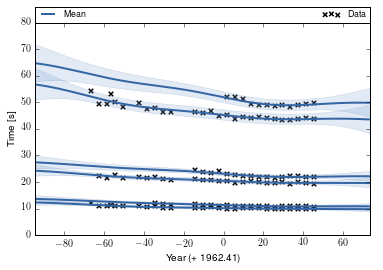

In [24]:
fig, ax = plt.subplots()
for i in range(2):
    for j in range(3):
        model.plot(fignum=1,fixed_inputs=[(1, i), (2, j)], 
                   ax=ax, legend=(i==0)*(j==0)*2, 
                   plot_data=(i==0)*(j==0))
ax.set_xlabel('Year (+ {})'.format(X2mean.round(2)))
ax.set_ylabel('Time [s]')

In [34]:
m.plot?

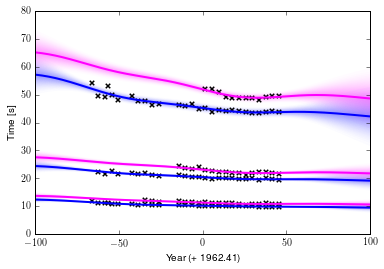

In [25]:
plotlim = (-100, 100)
fig, ax = plt.subplots()
for sex in range(2):
    c = 'magenta' if sex == 1 else 'blue'
    for event in range(3):
        conflabel = label = None
        if event == 0:
            label = ['Men', 'Women'][sex]
            conflabel = label+" 95\%"
        model.plot_mean(fixed_inputs=[(1, sex), (2, event)],
                   color=c, ax=ax, plot_limits=plotlim, label=label)
        model.plot_density(fixed_inputs=[(1, sex), (2, event)],
                   color=c, plot_limits=plotlim,
                  ax=ax, label=conflabel)
        
model.plot_data(visible_dims=[0], ax=ax)
ax.set_xlabel('Year (+ {})'.format(X2mean.round(2)))
ax.set_ylabel('Time [s]')
_ = ax.set_xlim(plotlim)

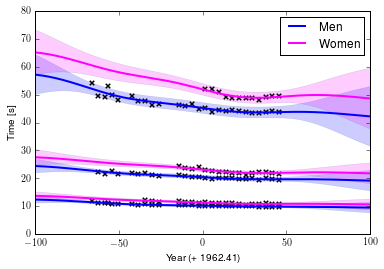

In [26]:
plotlim = (-100, 100)
fig, ax = plt.subplots()
for sex in range(2):
    c = 'magenta' if sex == 1 else 'blue'
    for event in range(3):
        conflabel = label = None
        if event == 0:
            label = ['Men', 'Women'][sex]
            conflabel = label+" 95\%"
        model.plot_mean(fixed_inputs=[(1, sex), (2, event)],
                   color=c, ax=ax, plot_limits=plotlim, label=label)
        model.plot_confidence(fixed_inputs=[(1, sex), (2, event)],
                   color=c, plot_limits=plotlim,
                  ax=ax, label=conflabel)
        
model.plot_data(visible_dims=[0], ax=ax)
ax.set_xlabel('Year (+ {})'.format(X2mean.round(2)))
ax.set_ylabel('Time [s]')
_ = ax.set_xlim(plotlim)

In [27]:
display(model)

GP_regression.,value,constraints,priors
mul.sum.rbf.variance,0.0132120051848,+ve,
mul.sum.rbf.lengthscale,36.4508323102,+ve,
mul.sum.linear.variances,1.84224719324e-06,+ve,
mul.sum.white.variance,0.000531301474393,+ve,
mul.sum.bias.variance,9.98742548332,+ve,
mul.gender.W,"(2, 1)",,
mul.gender.kappa,"(2,)",+ve,
mul.event.W,"(3, 1)",,
mul.event.kappa,"(3,)",+ve,
Gaussian_noise.variance,0.0117504562955,+ve,


## Low Rank Approximations

In the worst case, inference in a Gaussian process is $\mathcal{O}(n^3)$ computational complexity and $\mathcal{O}(n^2)$ storage. For efficient inference in larger data sets we need to consider approximations. One approach is low rank approximation of the covariance matrix (also known as sparse approximations or perhaps more accurately parsimonious approximations). We'll study these approximations by first creating a simple data set by sampling from a GP.

In [28]:
X = np.sort(np.random.rand(50,1)*12,0)
k = GPy.kern.RBF(1)
K = k.K(X)
K+= np.eye(50)*0.01 # add some independence (noise) to K
y = np.random.multivariate_normal(np.zeros(50), K).reshape(50,1)

Build a straightforward GP model of our simulation. We’ll also plot the posterior of $f$.

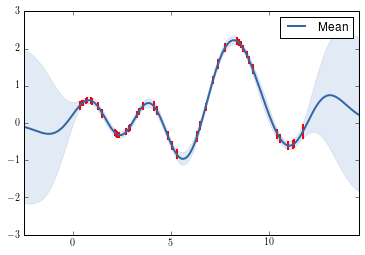

In [29]:
model = GPy.models.GPRegression(X,y)
model.optimize()
fig = plt.figure()
ax = fig.add_subplot(111)
model.plot_f(ax=ax)
model._raw_predict?
mu, var = model._raw_predict(X) # this fetches the posterior of f

plt.vlines(X[:,0], mu[:,0]-2.*np.sqrt(var[:,0]), mu[:,0]+2.*np.sqrt(var[:,0]),color='r',lw=2)

### Exercise 2

One thought that occurs is as follows. Do we need all the data to create this posterior estimate? Are any of the data points redundant? What happens to the model if you remove some data?

*Hint:* 
```python
X2 = np.delete(X,range(8),0)
y2 = np.delete(y,range(8),0)
```

In [30]:
# Exercise 2 answer here

### Building the Low Rank Approximation

Now we’ll consider a GP that uses a low rank approximation to fit the data.

In [31]:
Z = np.random.rand(3,1)*12
model = GPy.models.SparseGPRegression(X,y,Z=Z)
display(model)

sparse_gp.,value,constraints,priors
inducing inputs,"(3, 1)",,
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In GPy, the sparse inputs $\mathbf{Z}$ are abbreviated 'iip' , for inducing input. Plot the posterior
of $u$ in the same manner as for the full GP:

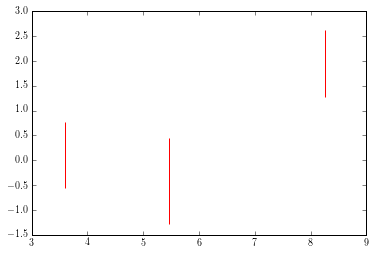

In [32]:
mu, var = model._raw_predict(Z) 
plt.vlines(Z[:,0], mu[:,0]-2.*np.sqrt(var[:,0]), mu[:,0]+2.*np.sqrt(var[:,0]),color='r')

### Exercise 3

Optimise and plot the model. The inducing inputs are marked – how
are they placed? You can move them around with e.g. `m['iip_2_0'] = 100` . What
happens to the likelihood? What happens to the fit if you remove an input?

In [33]:
# Exercise 3 answer

### Exercise 4

How does the fit of the sparse compare with the full GP? Play around
with the number of inducing inputs, the fit should improve as $M$ increases. How many
inducing points are needed? What do you think happens in higher dimensions?

### Exercise 5

Can you build a low rank Gaussian process with the intrinsic model of coregionalization? Do you have to treat the 2nd input (which specifies the event number) in a special way?

In [34]:
# Exercise 5 answer